##### Imports

In [338]:
import pandas as pd
import numpy as np
import pendulum

from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast.models import ARIMA

from sklearn import metrics

##### Configure plotting style

In [339]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

In [340]:
df = pd.read_csv("bases/History_Ibovespa_2014-2024.csv", usecols=[0,1], sep=',', parse_dates=['Data'])
df.sort_values(by=['Data'],inplace=True)
df.head()

/tmp/ipykernel_17084/761622389.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("bases/History_Ibovespa_2014-2024.csv", usecols=[0,1], sep=',', parse_dates=['Data'])


,Data,Último
2599,2014-01-02,50.341
2598,2014-01-03,50.981
2597,2014-01-06,50.974
2596,2014-01-07,50.430
2595,2014-01-08,50.577


In [341]:
df["unique_id"]="close"
df.columns=["ds","y","unique_id"]
df.head()

,ds,y,unique_id
2599,2014-01-02,50.341,close
2598,2014-01-03,50.981,close
2597,2014-01-06,50.974,close
2596,2014-01-07,50.430,close
2595,2014-01-08,50.577,close


In [342]:
print(df.dtypes)

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object


#### Explore data with the plot method

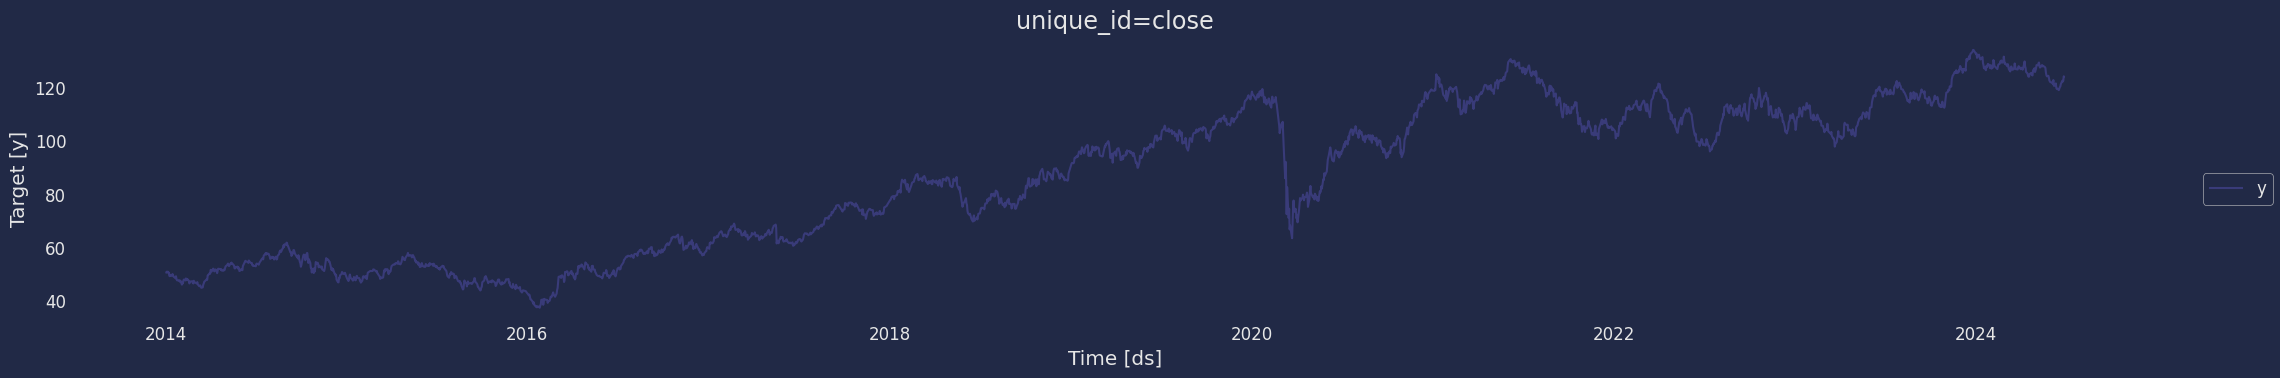

In [343]:
StatsForecast.plot(df)

count    2600.000000
mean       86.611760
std        27.350973
min        37.497000
25%        58.347500
50%        91.872000
75%       111.043500
max       134.194000
Name: y, dtype: float64

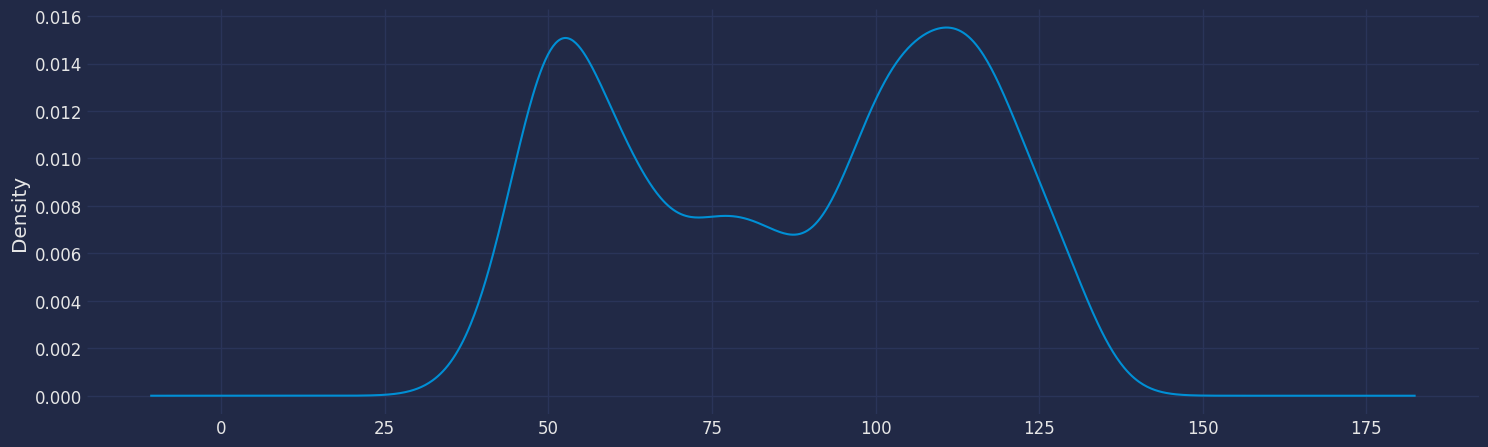

In [344]:
df["y"].plot(kind='kde',figsize = (16,5))
df["y"].describe()

##### Seasonal Decomposed

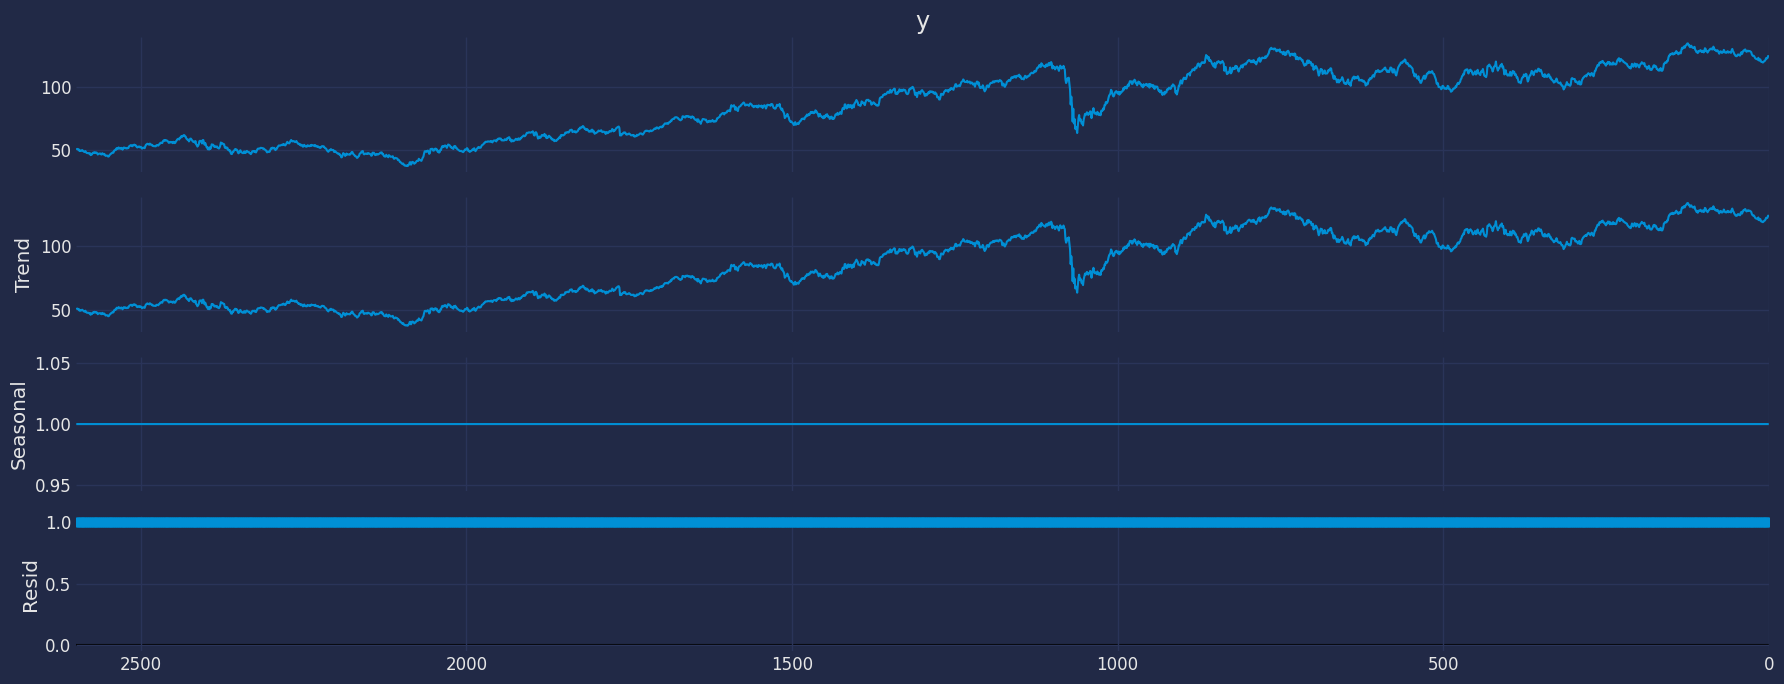

In [345]:
decomposed=seasonal_decompose(df["y"], model = "mul", period=1)
decomposed.plot()
plt.show()


In [346]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")


In [347]:
Augmented_Dickey_Fuller_Test_func(df["y"],"Life expectancy")


Dickey-Fuller test results for columns: Life expectancy
Test Statistic                   -1.223661
p-value                           0.663336
No Lags Used                      7.000000
Number of observations used    2592.000000
Critical Value (1%)              -3.432875
Critical Value (5%)              -2.862656
Critical Value (10%)             -2.567364
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary


#### Differentiate our time series

In [348]:
df1=df.copy()
df1['y_diff'] = df['y'].diff()
df1.dropna(inplace=True)
df1.head()


,ds,y,unique_id,y_diff
2598,2014-01-03,50.981,close,0.640
2597,2014-01-06,50.974,close,-0.007
2596,2014-01-07,50.430,close,-0.544
2595,2014-01-08,50.577,close,0.147
2594,2014-01-09,49.322,close,-1.255


In [349]:
Augmented_Dickey_Fuller_Test_func(df1["y_diff"],"Life expectancy")

Dickey-Fuller test results for columns: Life expectancy
Test Statistic                -1.788354e+01
p-value                        2.996112e-30
No Lags Used                   6.000000e+00
Number of observations used    2.592000e+03
Critical Value (1%)           -3.432875e+00
Critical Value (5%)           -2.862656e+00
Critical Value (10%)          -2.567364e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


##### Now our time series is stationary, that is, we have only differentiated 1 time, therefore, the order of our parameter: ``d=1``

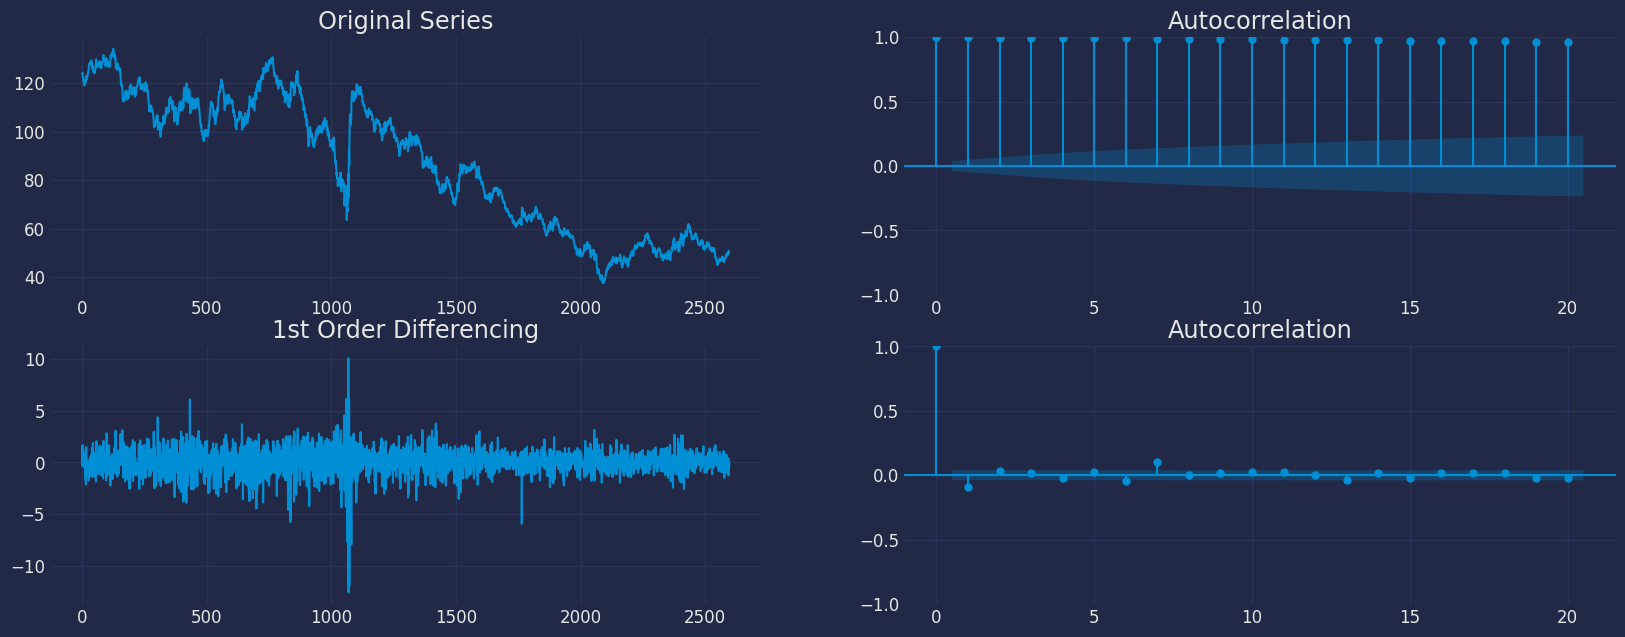

In [350]:
fig, axes = plt.subplots(2, 2, )
axes[0, 0].plot(df1["y"]); axes[0, 0].set_title('Original Series')
plot_acf(df1["y"], ax=axes[0, 1],lags=20)

axes[1, 0].plot(df1["y"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1["y"].diff().dropna(), ax=axes[1, 1],lags=20)


plt.show()


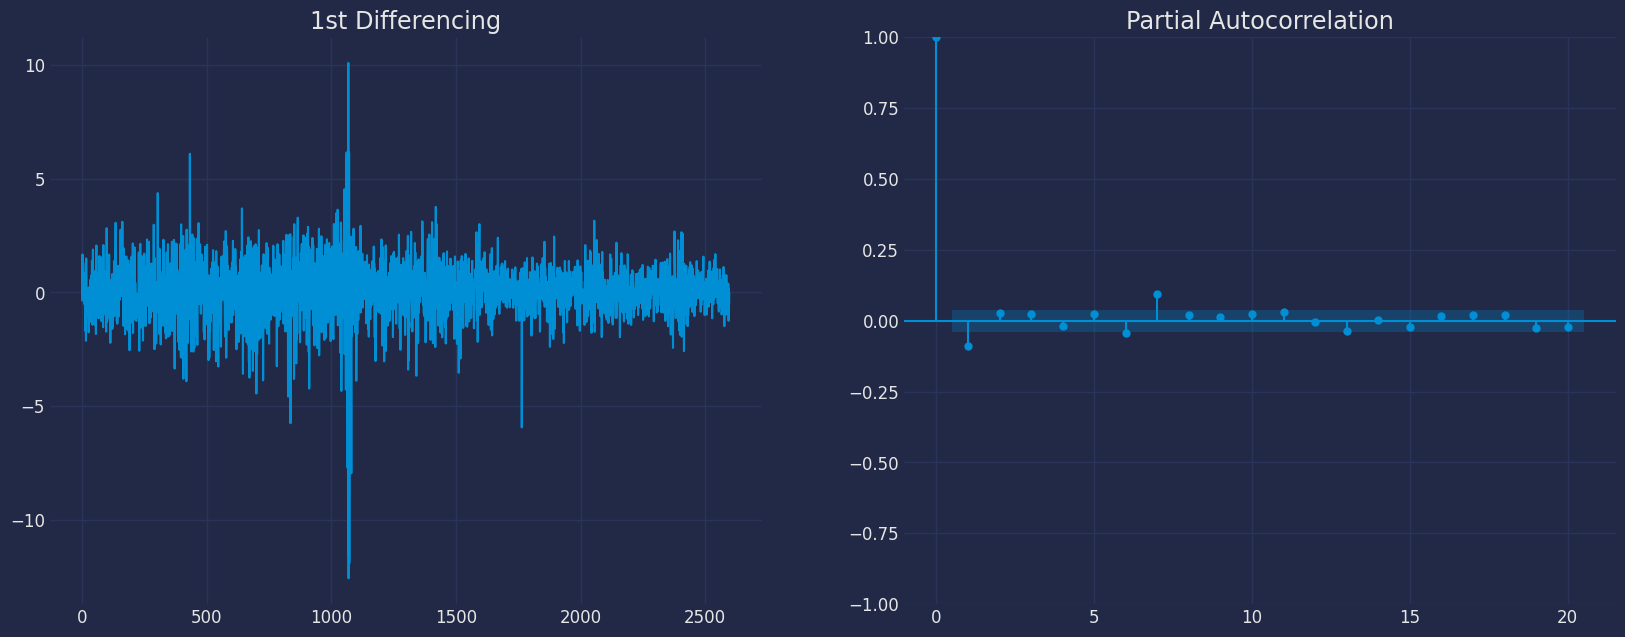

In [351]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df1["y"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df1["y"].diff().dropna(), ax=axes[1],lags=20)

plt.show()


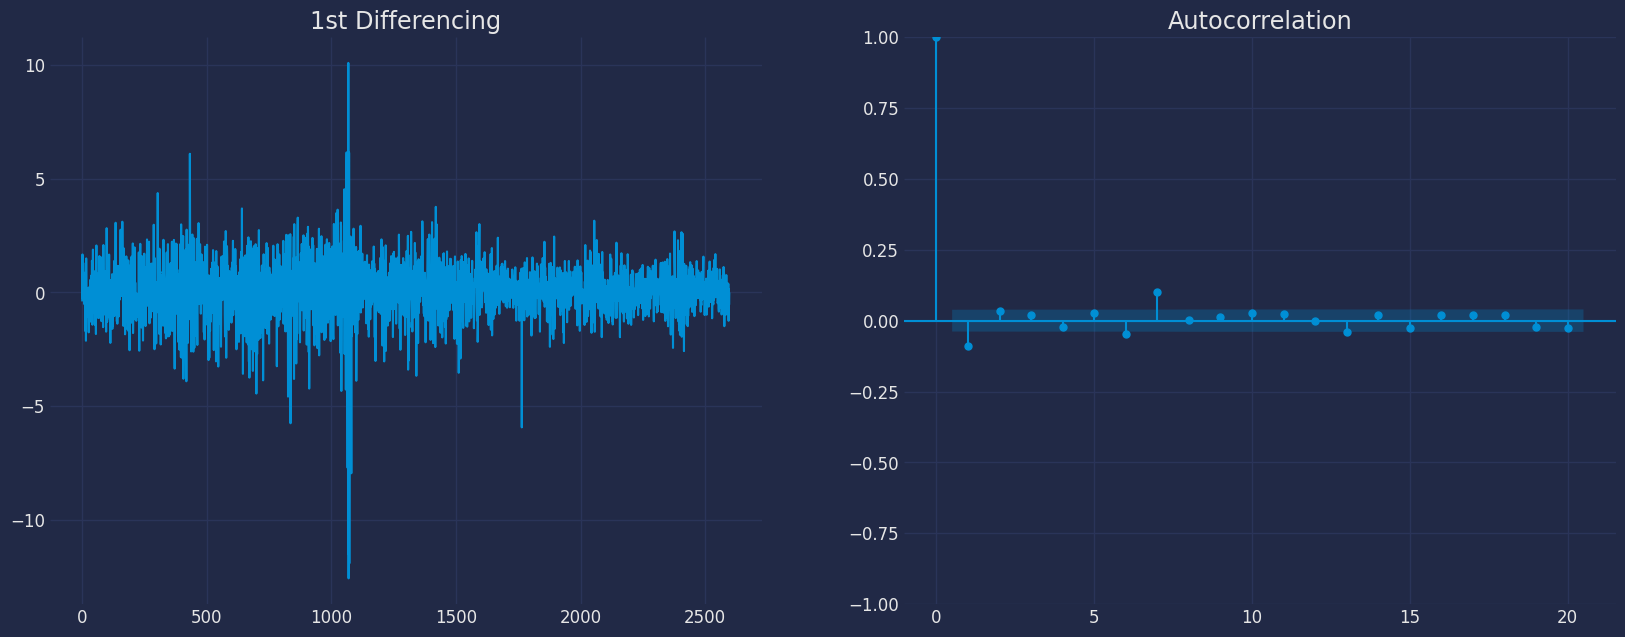

In [352]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 2)
axes[0].plot(df1["y"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df["y"].diff().dropna(), ax=axes[1], lags=20)

plt.show()


##### Modelling data

In [487]:
method = (1,0,0)

In [488]:
arima = ARIMA(order=method, season_length=1)
arima = arima.fit(y=df["y"].values)
y_hat_dict = arima.predict(h=20,)
y_hat_dict


{'mean': array([123.87379956, 123.84062887, 123.80748788, 123.77437658,
        123.74129494, 123.70824293, 123.67522052, 123.6422277 ,
        123.60926442, 123.57633067, 123.54342643, 123.51055165,
        123.47770632, 123.44489041, 123.4121039 , 123.37934675,
        123.34661894, 123.31392045, 123.28125125, 123.24861131])}

In [489]:
y_hat_dict2 = arima.predict(h=20,level=[95])
y_hat_dict2


{'mean': array([123.87379956, 123.84062887, 123.80748788, 123.77437658,
        123.74129494, 123.70824293, 123.67522052, 123.6422277 ,
        123.60926442, 123.57633067, 123.54342643, 123.51055165,
        123.47770632, 123.44489041, 123.4121039 , 123.37934675,
        123.34661894, 123.31392045, 123.28125125, 123.24861131]),
 'lo-95': 0     121.344268
 1     120.264933
 2     119.430132
 3     118.722104
 4     118.095209
 5     117.526032
 6     117.000655
 7     116.510006
 8     116.047781
 9     115.609388
 10    115.191358
 11    114.790995
 12    114.406154
 13    114.035096
 14    113.676385
 15    113.328823
 16    112.991394
 17    112.663231
 18    112.343582
 19    112.031797
 Name: 95%, dtype: float64,
 'hi-95': 0     126.403331
 1     127.416325
 2     128.184843
 3     128.826649
 4     129.387381
 5     129.890454
 6     130.349786
 7     130.774449
 8     131.170748
 9     131.543273
 10    131.895495
 11    132.230109
 12    132.549259
 13    132.854685
 14    133.1

In [490]:
Y_hat_df=arima.forecast(y=df["y"].values, h=20, fitted=True)
Y_hat_df


{'mean': array([123.87379956, 123.84062887, 123.80748788, 123.77437658,
        123.74129494, 123.70824293, 123.67522052, 123.6422277 ,
        123.60926442, 123.57633067, 123.54342643, 123.51055165,
        123.47770632, 123.44489041, 123.4121039 , 123.37934675,
        123.34661894, 123.31392045, 123.28125125, 123.24861131]),
 'fitted': array([ 51.88554526,  50.37369407,  51.01312081, ..., 122.29921122,
        122.60893355, 124.27444038])}

In [491]:
forecast=pd.Series(pd.date_range("2024-06-03", freq="B", periods=20))
forecast=pd.DataFrame(forecast)
forecast.columns=["ds"]
forecast["unique_id"]="1"
forecast["hat"]=y_hat_dict.get("mean")
forecast["lo-95"]=y_hat_dict2.get("lo-95")
forecast["hi-95"]=y_hat_dict2.get("hi-95")
forecast=forecast.set_index("ds")
forecast


,unique_id,hat,lo-95,hi-95
ds,,,,
2024-06-03,1,123.873800,121.344268,126.403331
2024-06-04,1,123.840629,120.264933,127.416325
2024-06-05,1,123.807488,119.430132,128.184843
2024-06-06,1,123.774377,118.722104,128.826649
2024-06-07,1,123.741295,118.095209,129.387381
2024-06-10,1,123.708243,117.526032,129.890454
2024-06-11,1,123.675221,117.000655,130.349786
2024-06-12,1,123.642228,116.510006,130.774449
2024-06-13,1,123.609264,116.047781,131.170748


In [492]:
df_2024 = df.loc[(df.ds>='2024-01-02') & (df.ds <= '2024-06-03')]

In [493]:
df_2024=df_2024.set_index("ds")

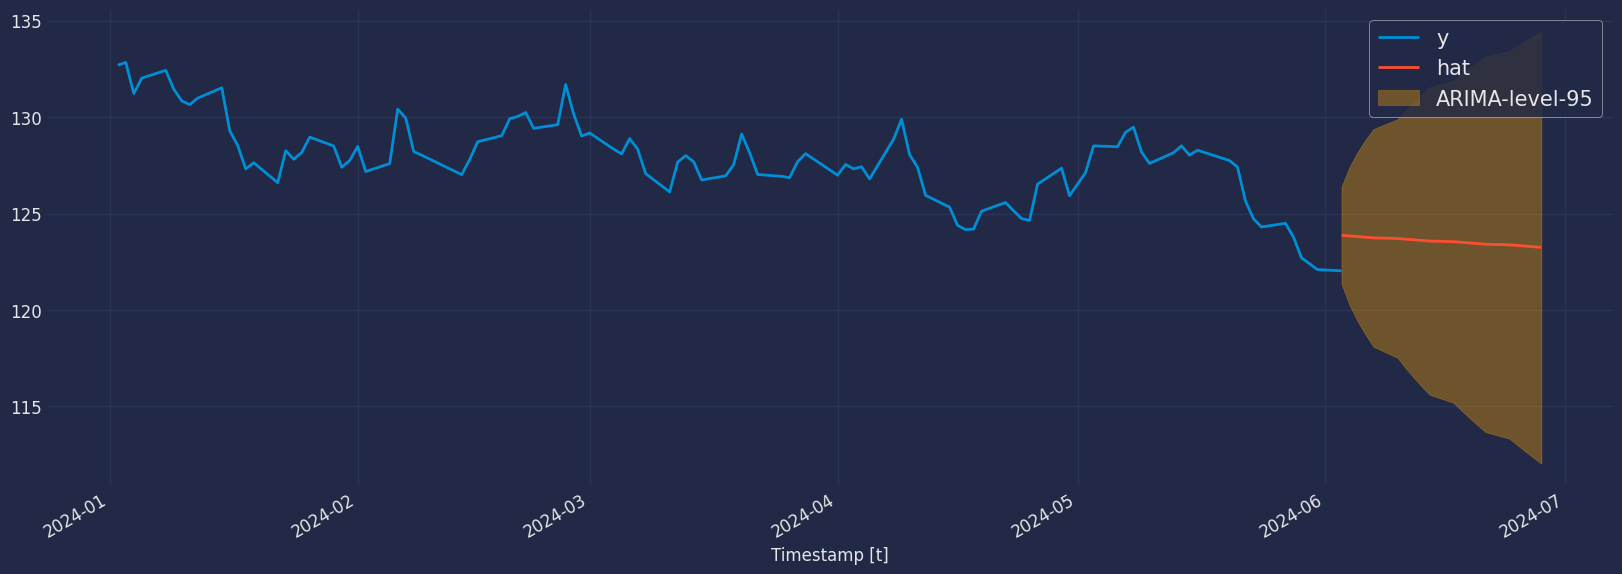

In [494]:
_, ax = plt.subplots(1, 1)
df_plot = pd.concat([df_2024, forecast])
df_plot[['y', 'hat']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['lo-95'], 
                df_plot['hi-95'],
                alpha=.35,
                color='orange',
                label='ARIMA-level-95')
ax.set_title('', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=12)
ax.legend(prop={'size': 15})
ax.grid(True)


In [518]:
Y_train_df = df[df.ds<='2024-05-31'] 
Y_test_df = df[df.ds>'2024-05-31']

Y_train_df.shape, Y_test_df.shape
Y_test_df = Y_test_df.set_index('ds')

##### Testing model

In [519]:
def register(method,mse,mae,rmse,mape,r2,corr):
    data = {
        'Method': method,
        'MSE': mse, 
        'MAE': mae, 
        'RMSE': rmse, 
        'MAPE': mape, 
        'R2': r2, 
        'corr': corr, 
        'time': pendulum.now().format("YYYY-MM-DD_HHmmss")
    }
    df_new = pd.DataFrame(data,index=[0])
    df_new.to_csv('bases/ARIMA_methods.csv',mode='a',index=False,header=False)

In [520]:
def model_evaluation(y_true, y_pred, Model, method):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) 
    
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0,1]
    
    method = str(method)
    register(method,mse,mae,rmse,mape,r2,corr)
    
    print (f'Model Evaluation: {Model}')
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    print(f'MAPE is : {mape:.2%}')
    print(f'R2 is : {r2}')
    print(f'corr is : {corr}',end='\n\n')


In [521]:
model_evaluation(Y_test_df["y"], forecast["hat"], "Arima", method)

Model Evaluation: Arima
MSE is : 7.139370068902086
MAE is : 2.373478818297013
RMSE is : 2.6719599676832897
MAPE is : 1.97%
R2 is : -2.457911603516328
corr is : -0.32434112134581355



In [524]:
Y_test_df.reset_index("ds", inplace=True)
forecast.reset_index("ds", inplace=True)
comp_df = Y_test_df.merge(forecast,on='ds')

In [526]:
comp_df[['ds','y','hat']]

,ds,y,hat
0,2024-06-03,122.032,123.873800
1,2024-06-04,121.802,123.840629
2,2024-06-05,121.407,123.807488
3,2024-06-06,122.899,123.774377
4,2024-06-07,120.767,123.741295
5,2024-06-10,120.760,123.708243
6,2024-06-11,121.635,123.675221
7,2024-06-12,119.936,123.642228
8,2024-06-13,119.568,123.609264
9,2024-06-14,119.662,123.576331
